In [1]:
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.task import task_constants
import pca_tools

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
def check_number_of_trials(xdict, samples, min_ntr):
    for key in samples:
        if xdict[key].shape[0] < min_ntr:
            return False
    return True

In [3]:
def select_trials_by_percentile(x: np.ndarray, mask: np.ndarray = None):
    ntr = x.shape[0]
    if mask is None:
        mask = np.full(ntr, True)

    mntr = x[mask].shape[0]

    if mntr < 2:
        return np.full(ntr, True)
    mean_trs = np.mean(x, axis=1)

    q25, q75 = np.percentile(mean_trs[mask], [25, 75])
    iqr = q75 - q25
    upper_limit = q75 + 1.5 * iqr
    lower_limit = q25 - 1.5 * iqr

    q1mask = mean_trs > lower_limit
    q2mask = mean_trs < upper_limit

    qmask = np.logical_and(q1mask, q2mask)
    return qmask


def check_trials(x, cerotr, percentile):
    masknocero = np.full(x.shape[0], True)
    maskper = np.full(x.shape[0], True)
    if cerotr:
        masknocero = np.sum(x, axis=1) != 0
    if percentile:
        maskper = select_trials_by_percentile(x, masknocero)
    mask = np.logical_and(masknocero, maskper)
    if np.sum(mask) < 5:
        mask = np.full(x.shape[0], True)
    return mask

In [4]:
def preproc_for_pca(
    neu: NeuronData,
    time_before_son: str,
    time_before_t1on: str,
    sp_son: str,
    sp_t1on: str,
    mask_son: str,
    min_ntr: int,
    start_sample: int,
    end_sample: int,
    start_test: int,
    end_test: int,
    avgwin: int = 100,
    step: int = 1,
    zscore=False,
    no_match=False,
    cerotr=False,
    percentile=False,  

    
):
    # Average fr across time
    idx_start_sample = int((getattr(neu, time_before_son) + start_sample) / step)
    idx_end_sample = int((getattr(neu, time_before_son) + end_sample) / step)
    idx_start_test = int((getattr(neu, time_before_t1on) + start_test) / step)
    idx_end_test = int((getattr(neu, time_before_t1on) + end_test) / step)
    sampleon = getattr(neu, sp_son)
    t1on = getattr(neu, sp_t1on)

    fr_son = firing_rate.moving_average(sampleon, win=avgwin, step=step)[
        :, idx_start_sample:idx_end_sample
    ]
    fr_t1on = firing_rate.moving_average(t1on, win=avgwin, step=step)[
        :, idx_start_test:idx_end_test
    ]

    fr = np.concatenate([fr_son, fr_t1on], axis=1)
    mask_son = getattr(neu, mask_son)
    sample_id = neu.sample_id[mask_son]
    if no_match:
        mask_no_match = np.where(
            neu.test_stimuli[mask_son, 0] == sample_id,
            False,
            True,
        )
        fr = fr[mask_no_match]
        sample_id = sample_id[mask_no_match]
    if len(fr) < 2:
        return None
    if zscore:
        fr_std = np.std(fr, ddof=1, axis=0)
        fr_std = np.where(fr_std == 0, 1, fr_std)
        fr = (fr - np.mean(fr, axis=0).reshape(1, -1)) / fr_std.reshape(1, -1)

    fr = np.array(fr, dtype=np.float32)
    fr_samples = select_trials.get_sp_by_sample(fr, sample_id)
    # check trials
    for isamp in fr_samples.keys():
        if ~np.all((np.isnan(fr_samples[isamp]))):
            masktr = check_trials(fr_samples[isamp], cerotr, percentile)
            fr_samples[isamp] = fr_samples[isamp][masktr]
            if fr_samples[isamp].shape[0] < min_ntr:
                return None
    
    samples = ["0","11", "15", "51", "55"]
    enough_tr = check_number_of_trials(fr_samples, samples, min_ntr)
    if not enough_tr:
        return None
    return fr_samples

In [5]:
def compute_pca(x, n_comp=50):
    model = PCA(n_components=n_comp).fit(x.T)
    C = model.components_
    pc_s = C @ x
    return model, pc_s

### Start preprocessing

In [6]:
save=False
savepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/percentile_with_nonzero/'
save_format = 'svg'
area = 'LIP'
rf_loc='in'

In [7]:
args={
    "preprocessing": {
        "min_ntr": 10,
        "start_sample": -200,
        "end_sample": 850,
        "start_test": -400,
        "end_test": 500,
        "step": 1,
        "time_before_son": "time_before_son_"+rf_loc,
        "time_before_t1on": "time_before_t1on_"+rf_loc,
        "sp_son": "sp_son_"+rf_loc,
        "sp_t1on": "sp_t1on_"+rf_loc,
        "mask_son": "mask_son_"+rf_loc,
        "zscore":False,
        "no_match": False,
        "cerotr":True,
        "percentile":True,
    },
    # workspace
    "workspace": {"output": "", "path": ""},
}

In [8]:
popu = PopulationData.from_python_hdf5(f"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/{area.lower()}/2024_08_28_12_23_36/population.h5")

In [9]:
trial_duration = int(
    (
        (args['preprocessing']["end_sample"] - args['preprocessing']["start_sample"])
        + (args['preprocessing']["end_test"] - args['preprocessing']["start_test"])
    )
    / args['preprocessing']["step"]
)
time_before_sample = getattr(popu.population[0],args['preprocessing']["time_before_son"])
start_sample = args['preprocessing']["start_sample"]
end_sample = args['preprocessing']["end_sample"]
# test timing
time_before_test = getattr(popu.population[0],args['preprocessing']["time_before_t1on"])
start_test = args['preprocessing']["start_test"]
end_test =args['preprocessing']["end_test"]

part1 = args['preprocessing']["end_sample"] -args['preprocessing']["start_sample"] 

idx_start_sample = time_before_sample + start_sample
idx_end_sample = time_before_sample + end_sample
idx_start_test = time_before_test + start_test
idx_end_test = time_before_test + end_test
# total trial duration

# Define epochs
part1 = end_sample-start_sample
test1_st = part1-start_test
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d1 = np.arange(200+450,part1,2)
idx_d2 = np.arange(part1,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test2_st,trial_duration,2)

In [10]:
greyscale=['#000000','#0F0F0F','#3D3D3D','#6B6B6B','#7A7A7A','#999999','#C7C7C7','#D6D6D6']
colors_g=['#001755','#002B95','#0036B3','#1A54D8','#3566DF','#4F79E5','#84A0F0','#9EB4F5']

In [11]:
# part 1 
t_epochs1 = {'fixation':idx_f,'sample':idx_s,'delay':idx_d1}#,'test3':idx_t3,'test4':idx_t4 'test2':idx_t2,
colors1 = {'epochs':{'fixation':colors_g[0],'sample':colors_g[2],'delay':colors_g[4]}}
colors_neu1 = {'epochs':{'fixation':greyscale[0],'sample':greyscale[2],'delay':greyscale[4]}}#
# part 2 
t_epochs2 = {'delay':idx_d2,'test1':idx_t1,'test off':idx_aftert}#,'test3':idx_t3,'test4':idx_t4 'test2':idx_t2,
colors2 = {'epochs':{'delay':colors_g[4],'test1':colors_g[6],'test2':colors_g[6],'test3':colors_g[6],'test4':colors_g[6],'test off':colors_g[-1]}}
colors_neu2 = {'epochs':{'delay':greyscale[4],'test1':greyscale[6],'test2':greyscale[5],'test3':greyscale[5],'test4':greyscale[5],'test off':greyscale[-1]}}#

In [12]:

list_data = popu.execute_function(
    preproc_for_pca,
    **args['preprocessing'],
    ret_df=False,
)
list_data = [idata for idata in list_data if idata is not None]

100%|██████████| 530/530 [00:11<00:00, 46.96it/s]


In [13]:
len(list_data)

466

In [14]:
fr_cells= np.empty((len(list_data),int(trial_duration*5)),dtype=np.float16)
for i,idata in enumerate(list_data):
    
    fr_cells[i] = np.concatenate((np.mean(idata ['0'],axis=0),np.mean(idata['11'],axis=0),np.mean(idata['15'],axis=0),np.mean(idata['51'],axis=0),np.mean(idata['55'],axis=0)))

In [15]:
n_comp=50
model,pc_s = compute_pca(fr_cells,n_comp=n_comp)

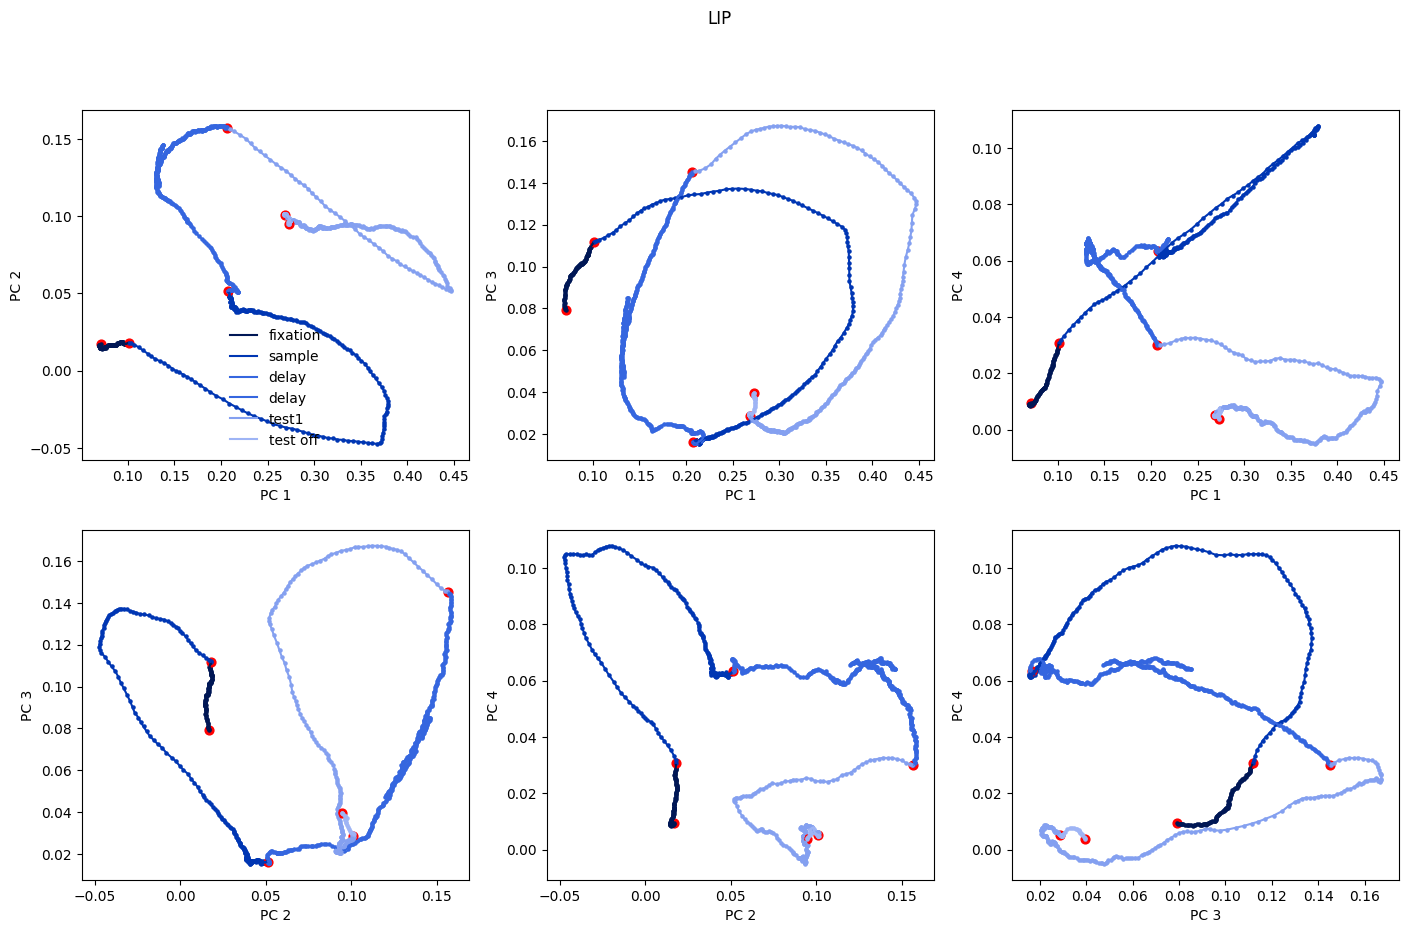

In [16]:
reshape_pc_s = pc_s.reshape(n_comp,-1,trial_duration)
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
fig, ax = plt.subplots(2, 3, figsize=(17,10))
pca_tools.plot_pc(mean_pc_s,colors1,t_epochs1,area,sample_flag = False,fig=fig, ax=ax,idot=0)
pca_tools.plot_pc(mean_pc_s,colors2,t_epochs2,area,sample_flag = False,fig=fig, ax=ax,idot=-1)
if save:
    figname = f'{area}_{rf_loc}_{len(list_data)}cells_pcs_sample_mean.{save_format}'
    fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

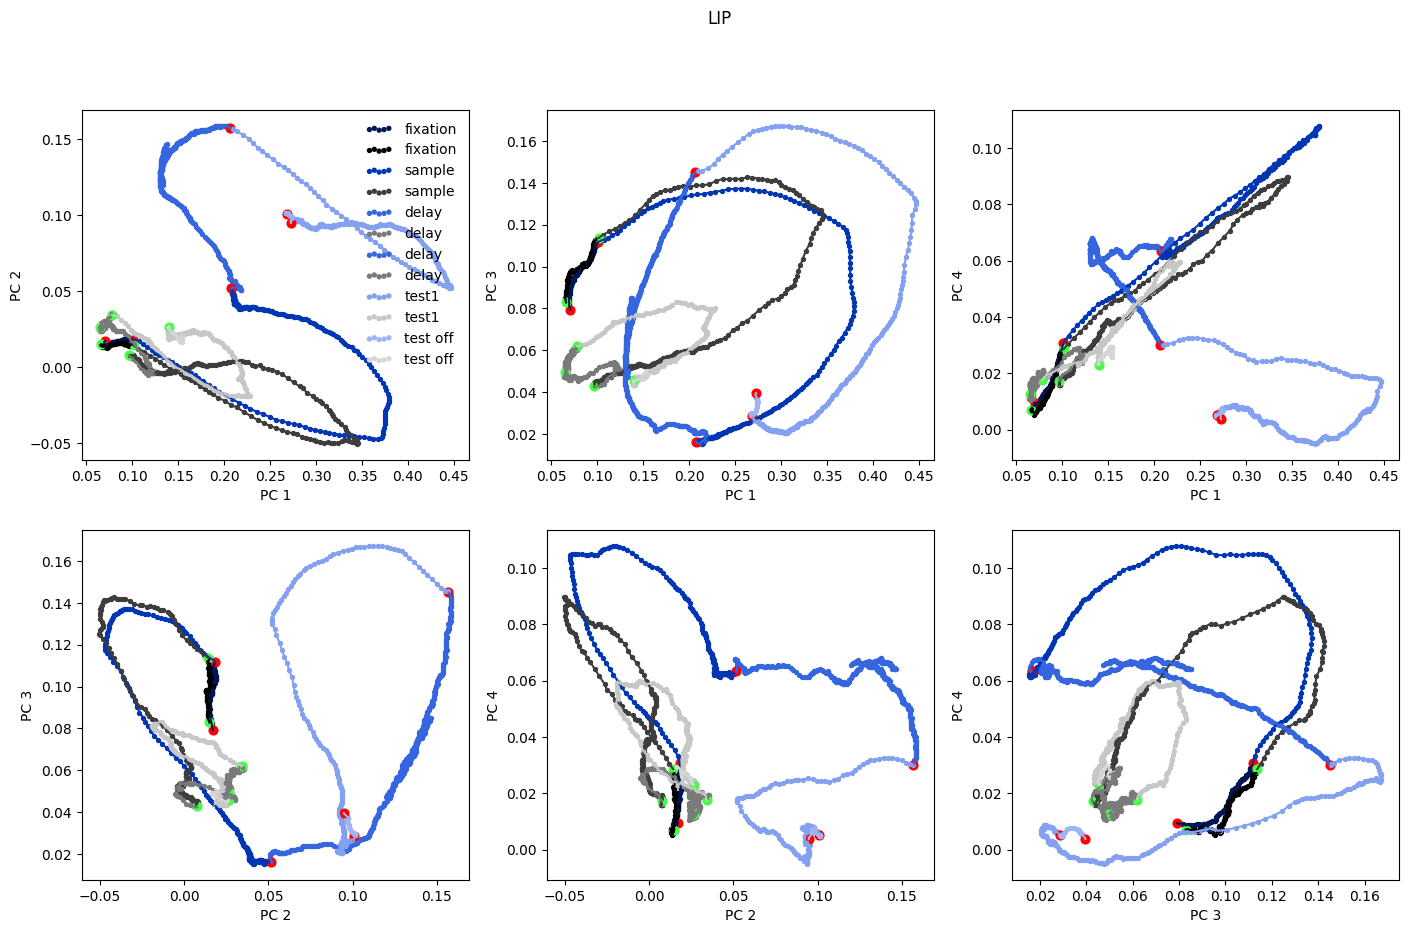

In [17]:

reshape_pc_s = pc_s.reshape(n_comp,-1,trial_duration)
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
fig, ax = plt.subplots(2, 3, figsize=(17,10))
pca_tools.plot_pc_neu(mean_pc_s,reshape_pc_s[:,0],colors1,colors_neu1,t_epochs1,area,fig=fig, ax=ax ,idot=0)
pca_tools.plot_pc_neu(mean_pc_s,reshape_pc_s[:,0],colors2,colors_neu2,t_epochs2,area,fig=fig , ax=ax,idot=-1)
if save:
    figname = f'{area}_{rf_loc}_{len(list_data)}cells_pcs_neutral_sample.{save_format}'
    fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

LIP: 3 components to explain 80% of the variance


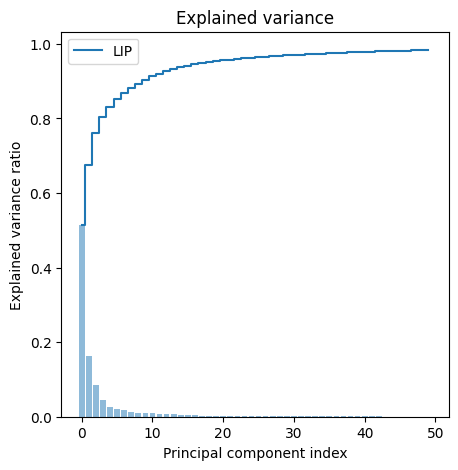

In [18]:
fig, ax = plt.subplots(figsize=(5,5))
pca_tools.plot_explained_var(model,figsize=(5,5),area=area,fig=fig,ax=ax)
if save:
    figname = f'{area}_{rf_loc}_{len(list_data)}cells_explained_var.{save_format}'
    fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")

In [19]:
%matplotlib widget

In [49]:
#fig.savefig('LIP_3d_2d_nnn_1.svg',format='svg',bbox_inches="tight")

In [39]:
from mpl_toolkits.mplot3d import Axes3D

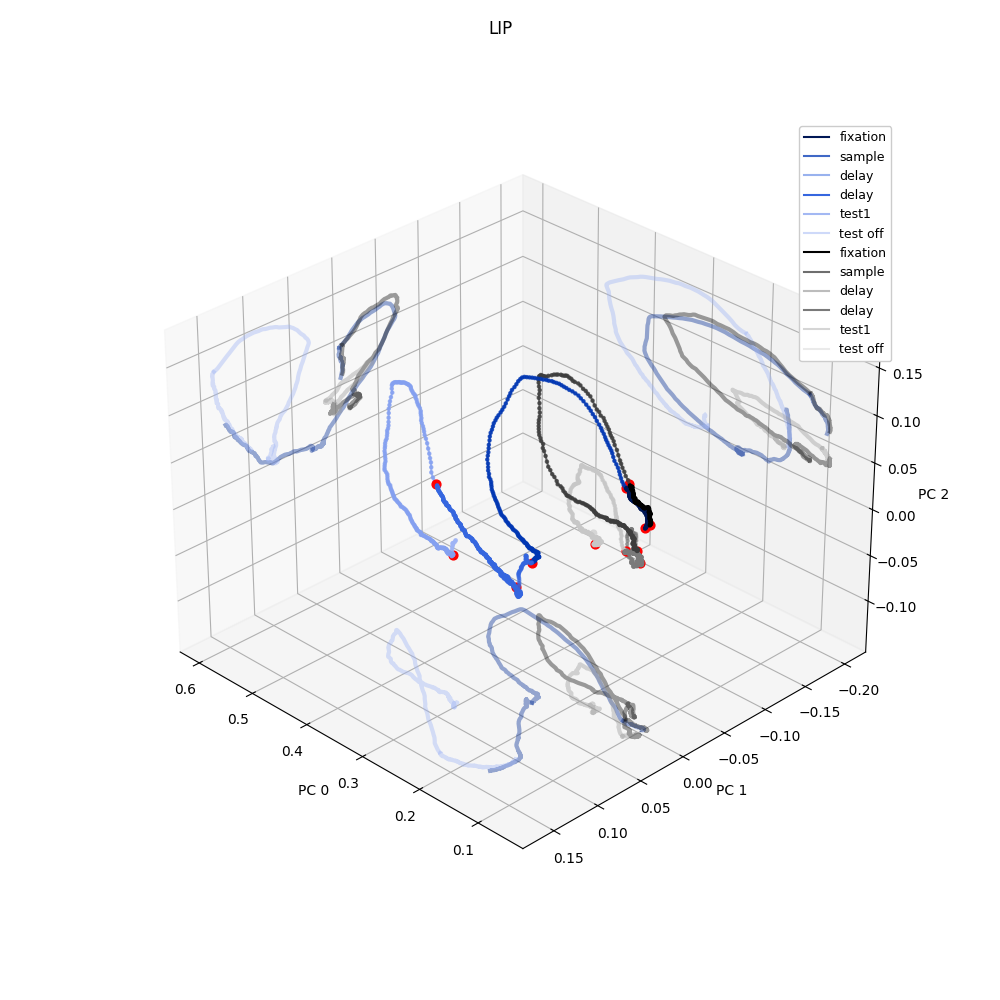

In [48]:
reshape_pc_s = pc_s.reshape(n_comp,-1,trial_duration)
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
neutral_pc_s = reshape_pc_s[:,0,:]
fig, ax = plt.subplots(
    figsize=(10,10), sharey=True, sharex=True, subplot_kw={"projection": "3d"}
)
pca_tools.plot_pc_3d(mean_pc_s,colors1,t_epochs1,area,fig=fig,ax=ax,sample_flag = False)
pca_tools.plot_pc_3d(mean_pc_s,colors2,t_epochs2,area,fig=fig,ax=ax,sample_flag = False)
pca_tools.plot_pc_3d(neutral_pc_s,colors_neu1,t_epochs1,area,fig=fig,ax=ax,sample_flag = False)
pca_tools.plot_pc_3d(neutral_pc_s,colors_neu2,t_epochs2,area,fig=fig,ax=ax,sample_flag = False)
i=0
min1=np.min(np.concatenate([mean_pc_s[i + 2],neutral_pc_s[i+2]]))-0.15
min2=np.min(np.concatenate([mean_pc_s[i + 1],neutral_pc_s[i+1]]))-0.15
min3=np.max(np.concatenate([mean_pc_s[i],neutral_pc_s[i]]))+0.15
for t_epochs,ccol in zip([t_epochs1,t_epochs2],['#002B95','#9EB4F5']):
    for  key in t_epochs.keys():
        label = colors1["sample"] if False else key
        ax.plot(
            mean_pc_s[i][t_epochs[key]],
            mean_pc_s[i + 1][t_epochs[key]],
            zdir='z',
            zs=min1,
            color=ccol,
            label=label,
            linewidth=3,
            alpha=0.4,
        )
        ax.plot(
            mean_pc_s[i][t_epochs[key]],
            mean_pc_s[i + 2][t_epochs[key]],
            zdir='y',
            zs=min2,
            color=ccol,
            label=label,
            linewidth=3,
            alpha=0.4,
        )
        ax.plot(
            mean_pc_s[i + 1][t_epochs[key]],
            mean_pc_s[i+2][t_epochs[key]],
            zdir='x',
            zs=min3,
            color=ccol,
            label=label,
            linewidth=3,
            alpha=0.4,
        )
for t_epochs,ccol in zip([t_epochs1,t_epochs2],['#0F0F0F','#999999']):
    for  key in t_epochs.keys():
        label = colors1["sample"] if False else key
        ax.plot(
            neutral_pc_s[i][t_epochs[key]],
            neutral_pc_s[i + 1][t_epochs[key]],
            zdir='z',
            zs=min1,
            color=ccol,
            label=label,
            linewidth=3,
            alpha=0.4,
        )
        ax.plot(
            neutral_pc_s[i][t_epochs[key]],
            neutral_pc_s[i + 2][t_epochs[key]],
            zdir='y',
            zs=min2,
            color=ccol,
            label=label,
            linewidth=3,
            alpha=0.4,
        )
        ax.plot(
            neutral_pc_s[i + 1][t_epochs[key]],
            neutral_pc_s[i+2][t_epochs[key]],
            zdir='x',
            zs=min3,
            color=ccol,
            label=label,
            linewidth=3,
            alpha=0.4,
        )
ax.view_init(elev=30, azim=135)

In [44]:
print(ax.azim)
print(ax.elev)

134.96103896103898
30.00000000000001


In [22]:
samples={
    "0": 0,
    "11": 1,
    "15": 2,
    "55": 3,
    "51": 4,   
}

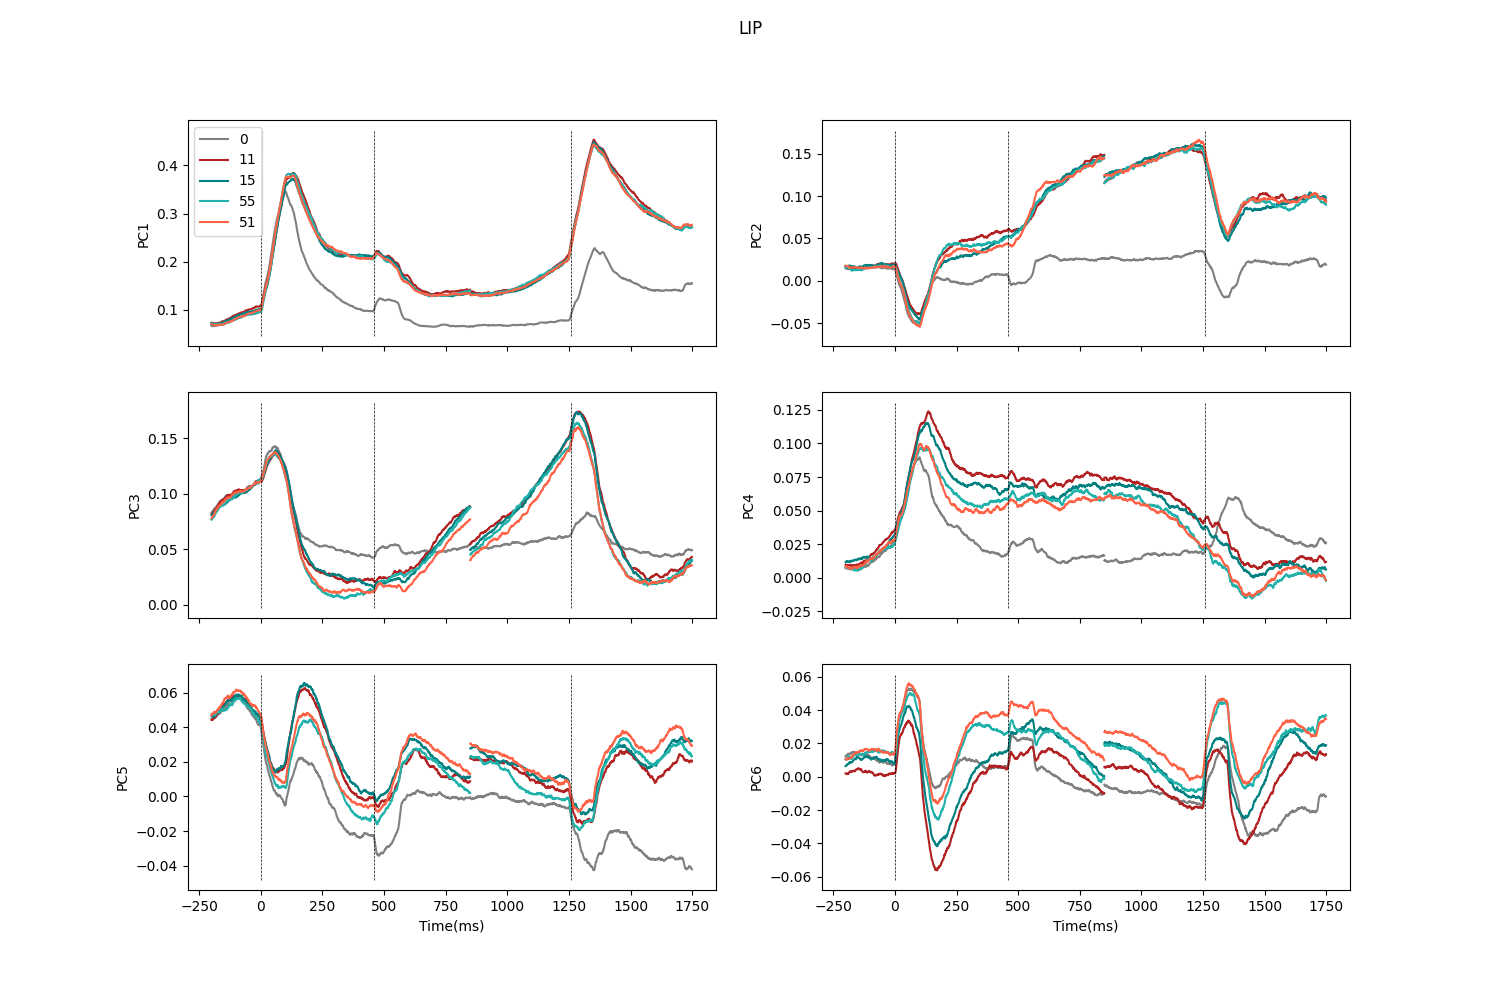

In [23]:

reshape_pc_s = pc_s.reshape(n_comp,-1,trial_duration)
fig,ax=plt.subplots(3,2,figsize=(15,10),sharex=True)
for i_sample in samples.keys():
    
    ax[0,0].plot((np.arange(trial_duration)-200)[:part1],reshape_pc_s[0,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[0,1].plot((np.arange(trial_duration)-200)[:part1],reshape_pc_s[1,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[1,0].plot((np.arange(trial_duration)-200)[:part1],reshape_pc_s[2,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[1,1].plot((np.arange(trial_duration)-200)[:part1],reshape_pc_s[3,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[2,0].plot((np.arange(trial_duration)-200)[:part1],reshape_pc_s[4,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)
    ax[2,1].plot((np.arange(trial_duration)-200)[:part1],reshape_pc_s[5,samples[i_sample],:part1],color=task_constants.PALETTE_B1[i_sample],label=i_sample)

    ax[0,0].plot((np.arange(trial_duration)-200)[part1:],reshape_pc_s[0,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
    ax[0,1].plot((np.arange(trial_duration)-200)[part1:],reshape_pc_s[1,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
    ax[1,0].plot((np.arange(trial_duration)-200)[part1:],reshape_pc_s[2,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
    ax[1,1].plot((np.arange(trial_duration)-200)[part1:],reshape_pc_s[3,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
    ax[2,0].plot((np.arange(trial_duration)-200)[part1:],reshape_pc_s[4,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])
    ax[2,1].plot((np.arange(trial_duration)-200)[part1:],reshape_pc_s[5,samples[i_sample],part1:],color=task_constants.PALETTE_B1[i_sample])

ax[0,0].vlines([0,458,1258],ax[0,0].get_ylim()[0],ax[0,0].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
ax[0,1].vlines([0,458,1258],ax[0,1].get_ylim()[0],ax[0,1].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
ax[1,0].vlines([0,458,1258],ax[1,0].get_ylim()[0],ax[1,0].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
ax[1,1].vlines([0,458,1258],ax[1,1].get_ylim()[0],ax[1,1].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
ax[2,0].vlines([0,458,1258],ax[2,0].get_ylim()[0],ax[2,0].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)
ax[2,1].vlines([0,458,1258],ax[2,1].get_ylim()[0],ax[2,1].get_ylim()[1],color='k',linestyle='--',linewidth=0.5)

ax[0,0].set(ylabel='PC1')
ax[0,1].set(ylabel='PC2')
ax[1,0].set(ylabel='PC3')
ax[1,1].set(ylabel='PC4')
ax[2,0].set(xlabel='Time(ms)',ylabel='PC5')
ax[2,1].set(xlabel='Time(ms)',ylabel='PC6')
ax[0,0].legend()
fig.suptitle(area)
if save:
    figname = f'{area}_{rf_loc}_{len(list_data)}cells_pcs_vs_time.{save_format}'
    fig.savefig(savepath+figname,format=save_format,bbox_inches="tight")